Praca domowa 5 (8 pkt.)
Termin: 13.05.2021 15:00

Dla wybranego modelu przygotuj knitr/jupyter notebook w formacie html lub pdf rozwiązując poniższe punkty. Pracę domową należy zgłosić przez Pull Request na GitHub w folderze PraceDomowe/PracaDomowa5/Nazwisko_Imię.

    Dla wybranych zmiennych ze zbioru danych policz Partial Dependence Profiles (PDP)
    Dla wybranych zmiennych ze zbioru danych policz Accumulated Local Dependence (ALE).
    Wypróbuj różne kombinacje rozmiaru siatki oraz rozkładu jej punktów. Opisz wpływ na krzywe
    Skomentuj i porównaj wyniki uzyskane w powyższych punktach, połóż nacisk na różnice pomiędzy krzywymi PDP i ALE.

W pracy domowej oceniane przede wszystkim będą wnioski z otrzymanych analiz. Kod potrzebny do reprudokowalności wyników również proszę załączyć.

Prace domowe należy zgłaszać przez Pull Request o tytule Nazwisko Imię PD5. Wszystkie pliki związane z pracą domową proszę o umieszczenie w folderze Nazwisko_Imię.

In [1]:
suppressWarnings(suppressMessages(library(OpenML)))
suppressWarnings(suppressMessages(library(mlr)))
suppressWarnings(suppressMessages(library(pROC)))
suppressWarnings(suppressMessages(library(plyr)))
suppressWarnings(suppressMessages(library(DALEX)))
suppressWarnings(suppressMessages(library(DALEXtra)))

set.seed(4)

diabetes <- read.csv("diabetes.csv")

diabetes$class[diabetes$class == "tested_positive"] <- 1
diabetes$class[diabetes$class == "tested_negative"] <- 0
head(diabetes)


,preg,plas,pres,skin,insu,mass,pedi,age,class
,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<chr>
1,6,148,72,35,0,33.6,0.627,50,1
2,1,85,66,29,0,26.6,0.351,31,0
3,8,183,64,0,0,23.3,0.672,32,1
4,1,89,66,23,94,28.1,0.167,21,0
5,0,137,40,35,168,43.1,2.288,33,1
6,5,116,74,0,0,25.6,0.201,30,0


In [2]:
m <- sample(1:nrow(diabetes), 0.7*nrow(diabetes))
diabetes_train <- diabetes[m,]
diabetes_test <- diabetes[-m,]

In [3]:
classif_task <- makeClassifTask(id = "lvr", data = diabetes_train, target = "class")
classif_lrn <- makeLearner("classif.ranger", predict.type = "prob")
model <- train(classif_lrn, classif_task)

In [4]:
explainer <- DALEX::explain(model = model,
                     data = diabetes,
                     y = diabetes$class)

Preparation of a new explainer is initiated
  -> model label       :  WrappedModel  (  default  )
  -> data              :  768  rows  9  cols 
  -> target variable   :  768  values 
  -> predict function  :  yhat.WrappedModel  will be used (  default  )
  -> predicted values  :  numerical, min =  6e-04 , mean =  0.3544127 , max =  0.9311175  
  -> model_info        :  package mlr , ver. 2.19.0 , task classification (  default  ) 
  -> model_info        :  Model info detected classification task but 'y' is a character .  (  WARNING  )
  -> model_info        :  By deafult classification tasks supports only numercical 'y' parameter. 
  -> model_info        :  Consider changing to numerical vector with 0 and 1 values.
  -> model_info        :  Otherwise I will not be able to calculate residuals or loss function.
  -> residual function :  difference between y and yhat (  default  )
  -> residuals         :  the residual_function returns an error when executed (  WARNING  ) 
  A new explain

# PDP

In [5]:
pdp <- model_profile(explainer,variables = c("plas","mass","preg"))

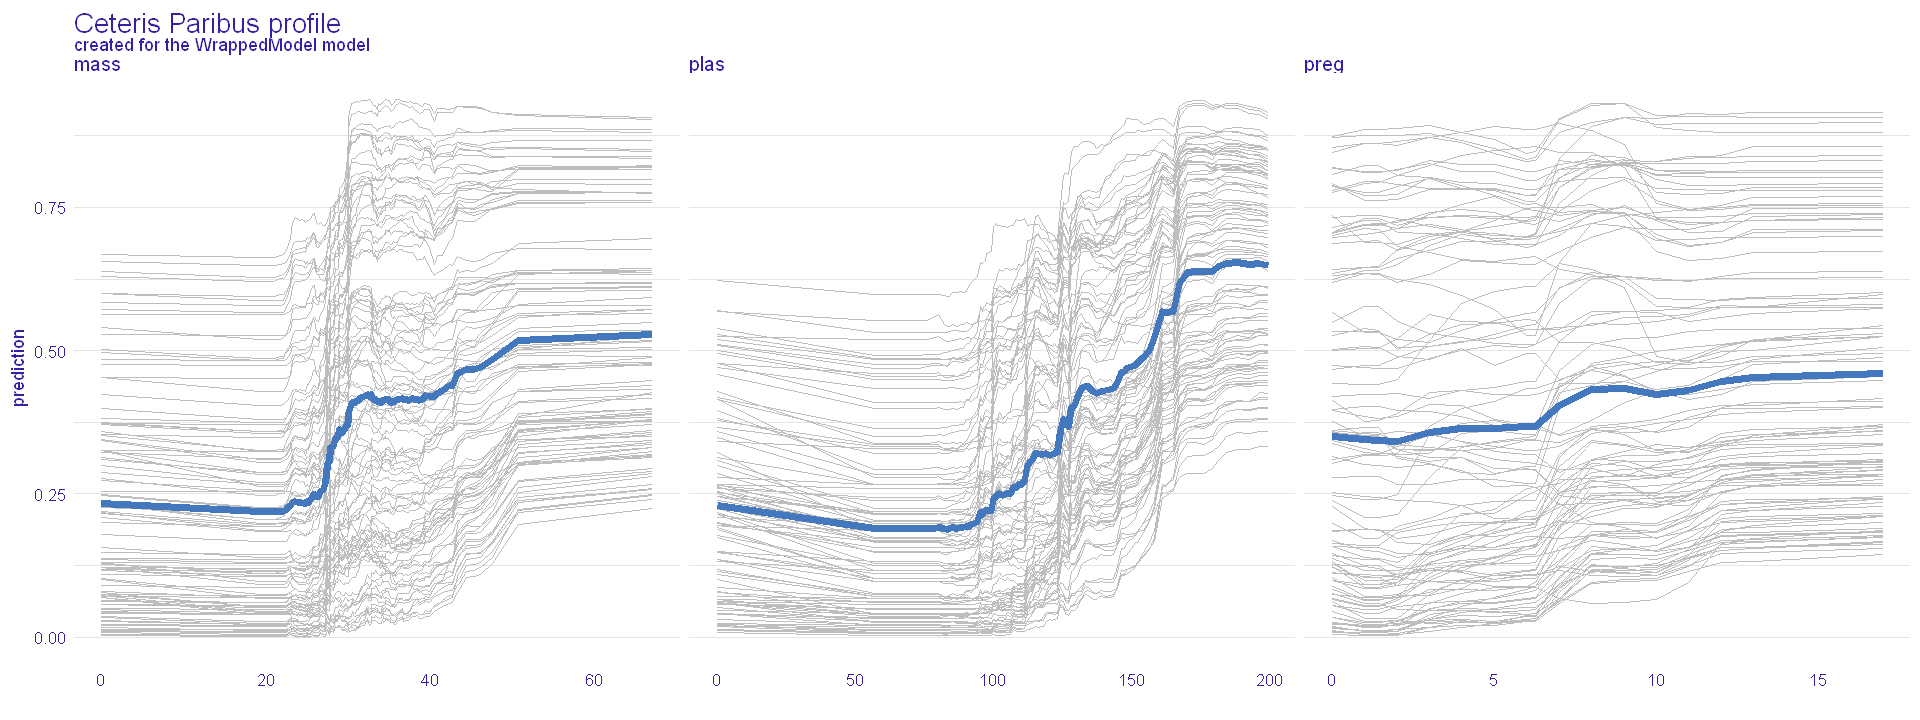

In [6]:
options(repr.plot.width=16, repr.plot.height=6)
plot(pdp, geom = "profiles")

Średnio dla masy >= 25 predykcja gwałtownie się zwiększa. Podobnie dla plas >= 100 predykcja szybko rośnie. Dla preg natomiast zmienna niewiele zwiększa predykcję wraz ze swoją wartością.

# ALE

In [7]:
ale <- model_profile(explainer,variables = c("plas","mass","preg"),type="accumulated")

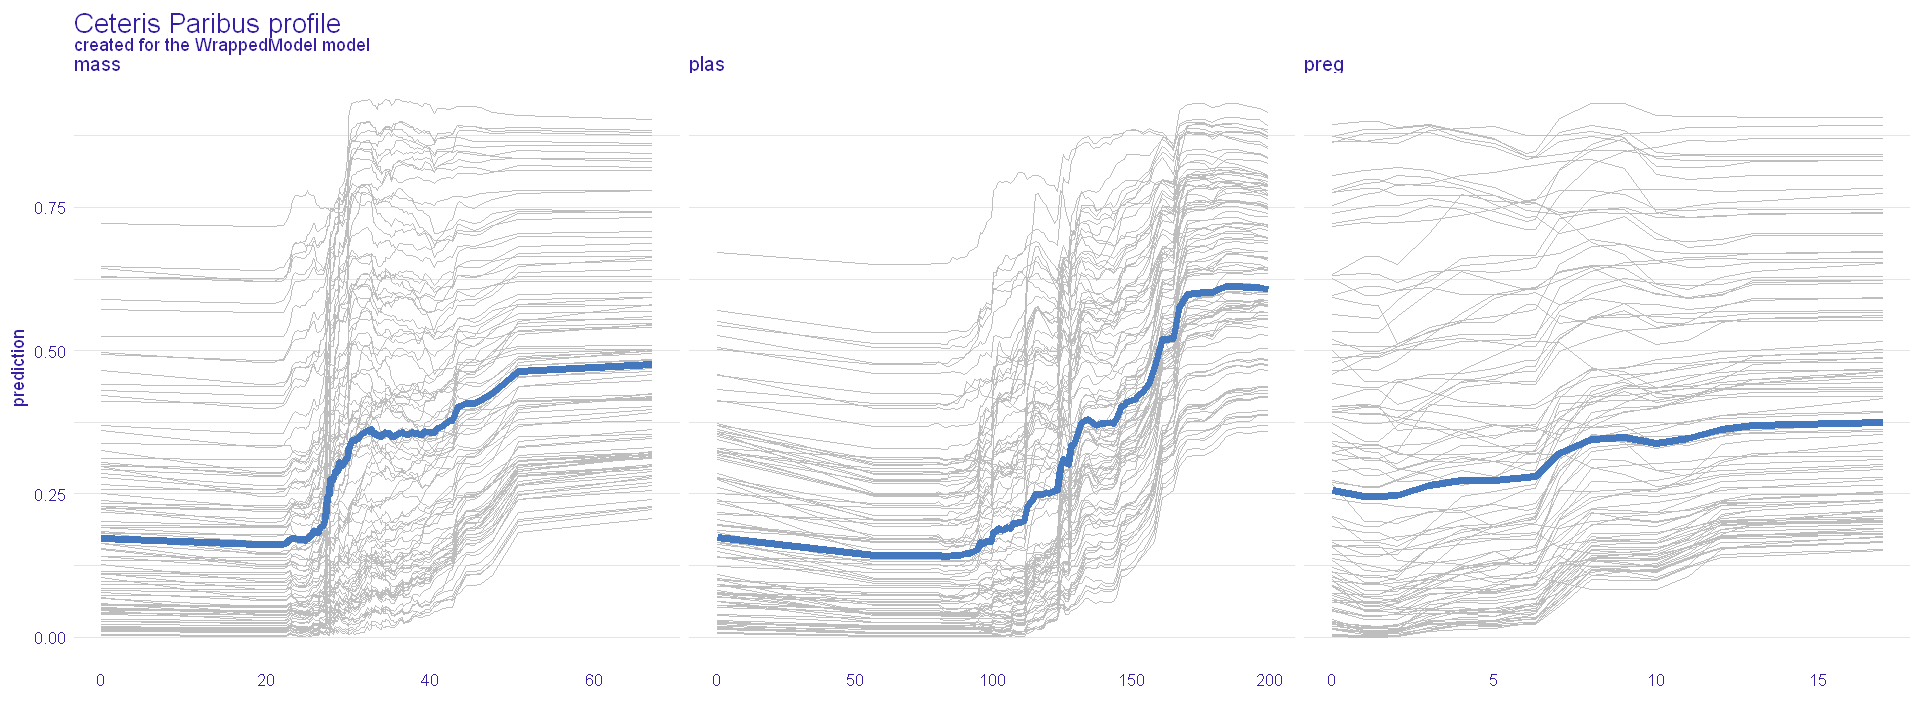

In [8]:
plot(ale, geom = "profiles")

Wnioski podobne jak w PDP

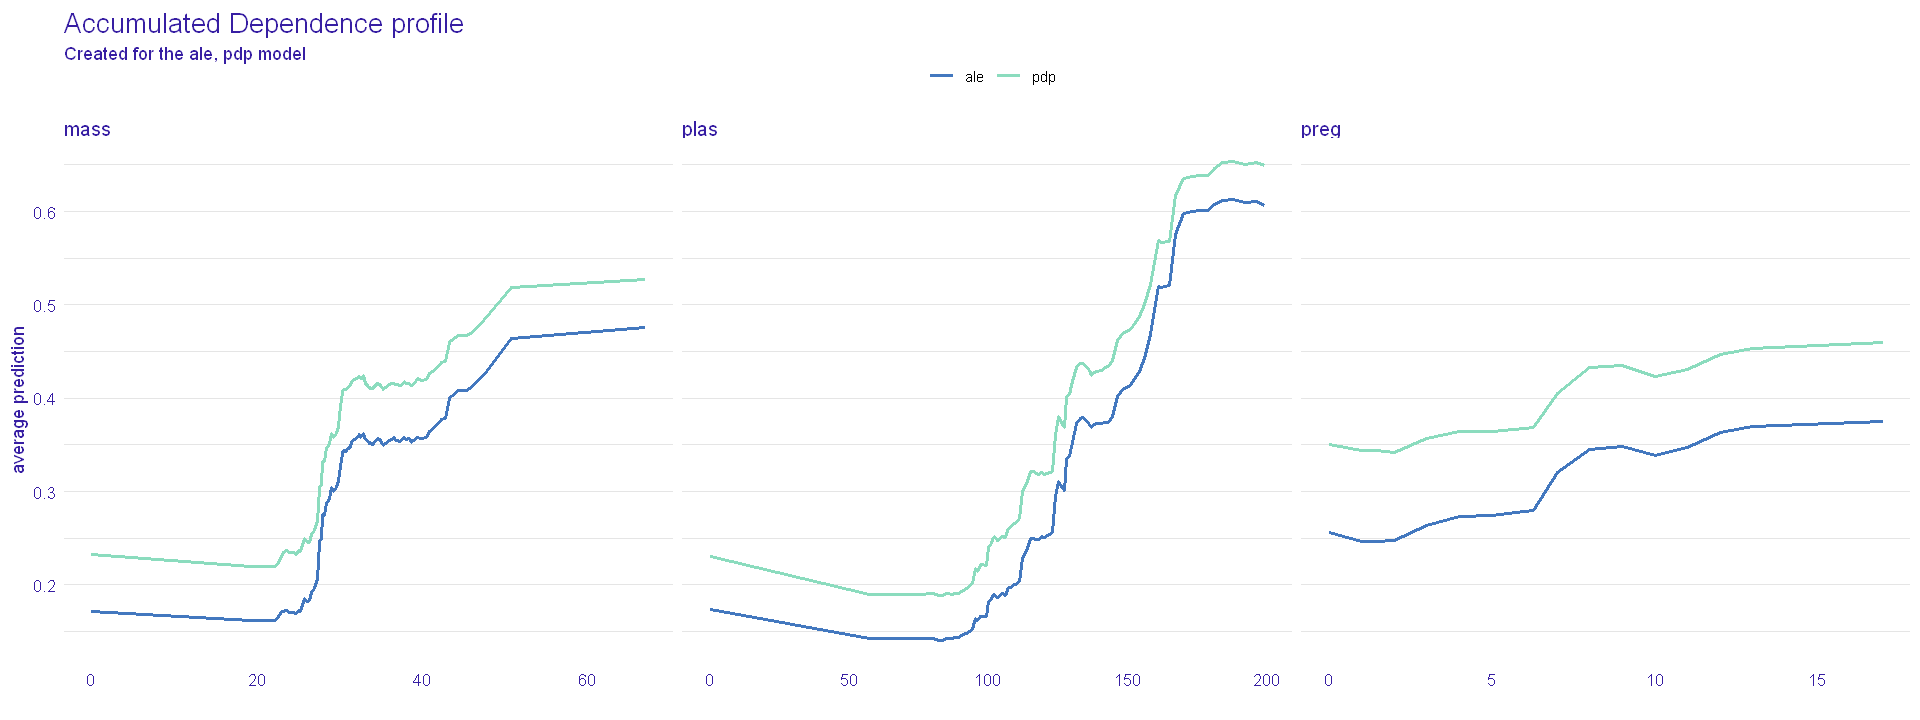

In [9]:
ale$agr_profiles$`_label_` <- "ale"
pdp$agr_profiles$`_label_` <- "pdp"
plot(ale, pdp)

PDP i ALE różnią się w niewielkim stopniu co świadczy o niewielkiej korelacji zmiennych.

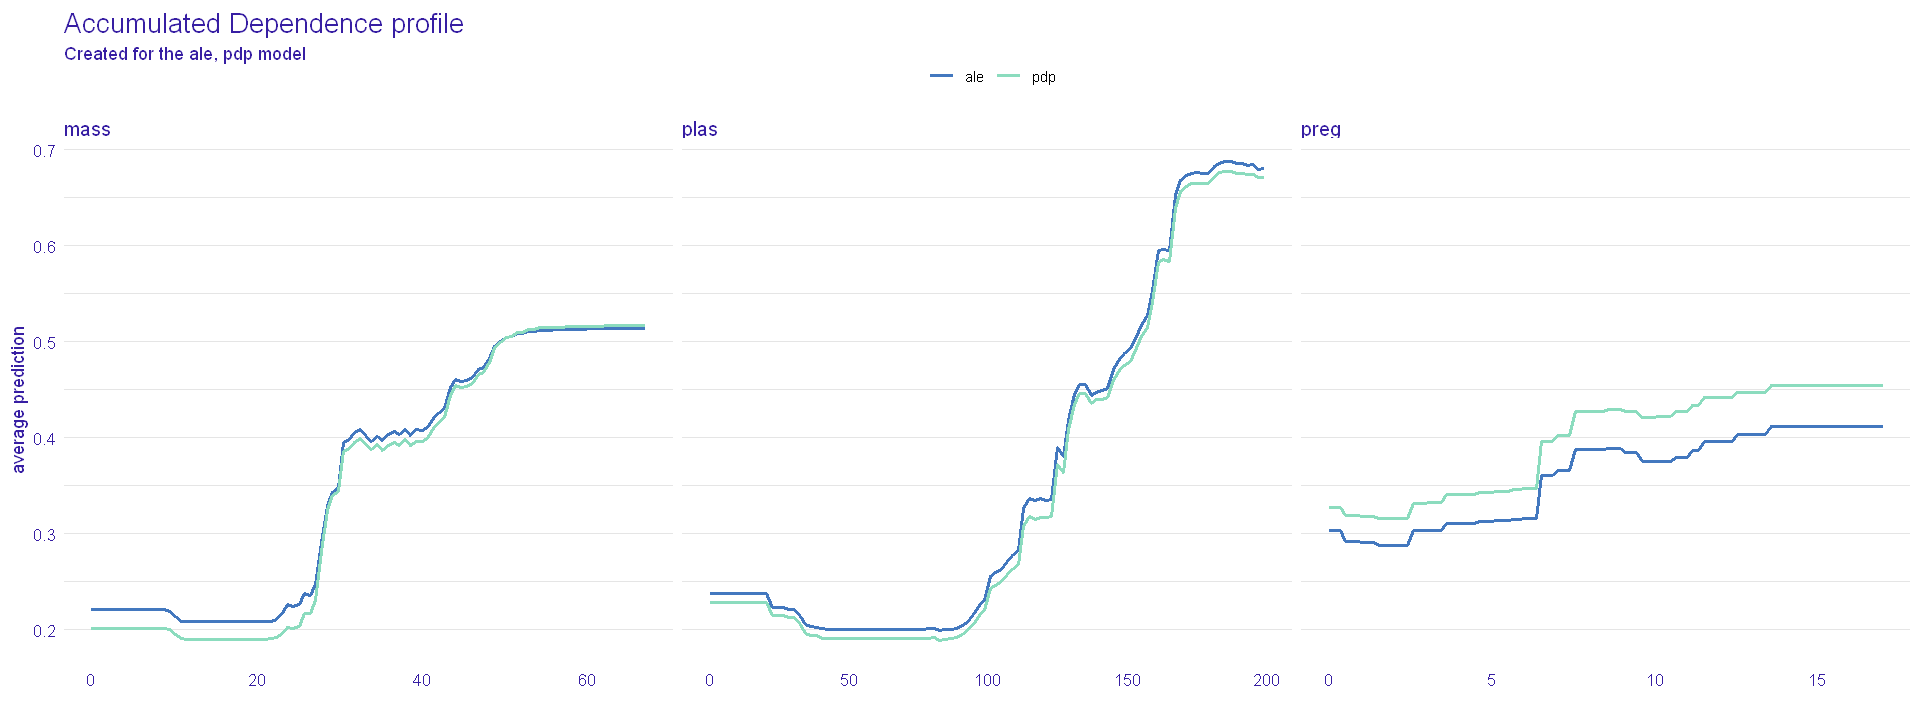

In [10]:
pdp <- model_profile(explainer,variables = c("plas","mass","preg"),grid_points = 100, variable_splits_type = "uniform")
ale <- model_profile(explainer,variables = c("plas","mass","preg"),type="accumulated",grid_points = 100, variable_splits_type = "uniform")
ale$agr_profiles$`_label_` <- "ale"
pdp$agr_profiles$`_label_` <- "pdp"
plot(ale, pdp)

Zastosowanie rozdzielenia typu uniform znacznie zbliżyło do siębie wyniki PDP i ALE

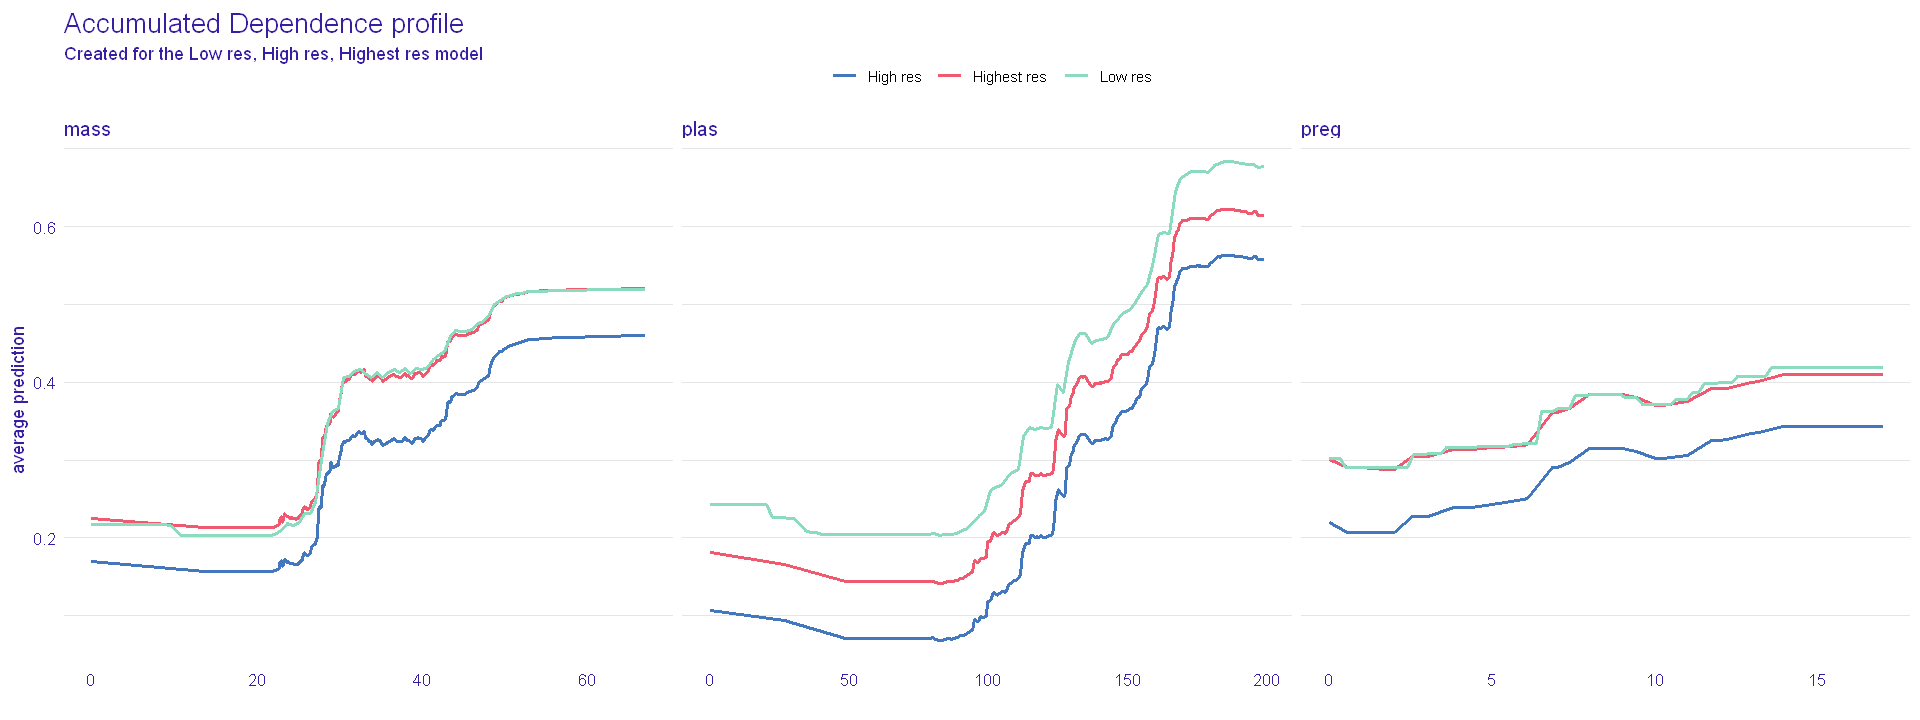

In [11]:
aleC <- model_profile(explainer,variables = c("plas","mass","preg"),type="accumulated",N = 1000,grid_points = 1000)
aleB <- model_profile(explainer,variables = c("plas","mass","preg"),type="accumulated",grid_points = 1000)
aleA <- model_profile(explainer,variables = c("plas","mass","preg"),type="accumulated",grid_points = 100, variable_splits_type = "uniform")
aleC$agr_profiles$`_label_` <- "Highest res"
aleB$agr_profiles$`_label_` <- "High res"
aleA$agr_profiles$`_label_` <- "Low res"
plot(aleA, aleB, aleC)

Największą różnicę w "łagodności" krzywych widać dla preg. Dla mniejszej liczby punktów, krzywa jest bardziej kanciasta. Nieznacznie zmieniało się też przesunieńcie krzywej.